In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import *
from keras.models import Sequential
from scipy import stats
from sklearn.metrics import confusion_matrix
from pylab import rcParams
from IPython.display import set_matplotlib_formats

# config
%matplotlib inline
set_matplotlib_formats('retina')
rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
WISDM_DATASET_PATH = "../data/WISDM_ar_v1.1_raw.txt"
COLUMNS = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [3]:
def convert_to_float(dataset_value):
    try:
        return np.float(dataset_value)
    except:
        return np.nan

    
def convert_to_int(dataset_value):
    try:
        return np.int(dataset_value)
    except:
        return np.nan


def normalise_feature(feature):
    mu = np.mean(feature, axis=0)
    sigma = np.std(feature, axis=0)
    return (feature - mu)/sigma


def process_and_load_WISDM_file_to_memory(file_path, column_names):
    dataset = pd.read_csv(file_path, header=None, names=column_names)
    # Remove ';' and convert z-axis column to float values
    dataset['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    dataset['z-axis'] = dataset['z-axis'].apply(convert_to_float)
    # Drop rows with 'NA' values to prevent NAN errors
    dataset = dataset.dropna(inplace=False)
    # Round acceleration values to four decimal places
    dataset = dataset.round({'x-axis': 5, 'y-axis': 5, 'z-axis': 5})
    # Apply normalisation to the acceleration values
    dataset['x-axis'] = normalise_feature(dataset['x-axis'])
    dataset['y-axis'] = normalise_feature(dataset['y-axis'])
    dataset['z-axis'] = normalise_feature(dataset['z-axis'])
    return dataset


def create_data_segmentation_and_activity_labels(dataset, window, increment):
    segmented_dataset = []
    activity_labels = []

    for i in range(0, len(dataset) - window, increment):
        x_axis = dataset['x-axis'].values[i: i + window]
        y_axis = dataset['y-axis'].values[i: i + window]
        z_axis = dataset['z-axis'].values[i: i + window]
        activity_label = stats.mode(dataset['activity'][i: i + window])[0][0]
        activity_labels.append(activity_label)
        segmented_dataset.append([x_axis, y_axis, z_axis])
    
    segmented_dataset = np.asarray(segmented_dataset, dtype=np.float32)
    transposed_segments = segmented_dataset.reshape(-1, window, 3)
    return transposed_segments, activity_labels


def split_dataset(df):
    df['user'] = df['user'].apply(convert_to_int)
    train_df = df[df['user'] <= 29]
    test_df = df[df['user'] > 29]
    return train_df, test_df


def apply_one_hot_encoding(activities_labels):
    activities_labels = pd.get_dummies(activities_labels)
    activities_labels = np.asarray(activities_labels, dtype = np.float32)
    return activities_labels


def test_model(df):
    segments, labels = create_data_segmentation_and_activity_labels(df, window_size, step_size)
    labels = apply_one_hot_encoding(labels)
    score = model.evaluate(segments, labels, verbose=1)
    return score

In [4]:
window_size = 200
step_size = 20
df = process_and_load_WISDM_file_to_memory(WISDM_DATASET_PATH, COLUMNS)
train_df, test_df = split_dataset(df)
segments, labels = create_data_segmentation_and_activity_labels(train_df, window_size, step_size)
labels = apply_one_hot_encoding(labels)

In [5]:
def create_CNNM4():
    model = Sequential()
    model.add(Conv1D(64, 10, activation='relu', input_shape=(window_size, 3)))
    model.add(Conv1D(64, 10, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def create_CNNM3():
    model = Sequential()
    model.add(Conv1D(64, 5, activation='relu', input_shape=(window_size, 3)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_CNNM2():
    model = Sequential()
    model.add(Conv1D(32, 32, activation='relu', input_shape=(window_size, 3)))
    model.add(MaxPooling1D(7))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def create_CNNM1():
    model = Sequential()
    model.add(Conv1D(32, 32, activation='relu', input_shape=(window_size, 3)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = create_CNNM4()
model.summary()
history = model.fit(segments, labels, validation_split=0.2, epochs=20, batch_size=1024, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 191, 64)           1984      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 182, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 128)           41088     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxP

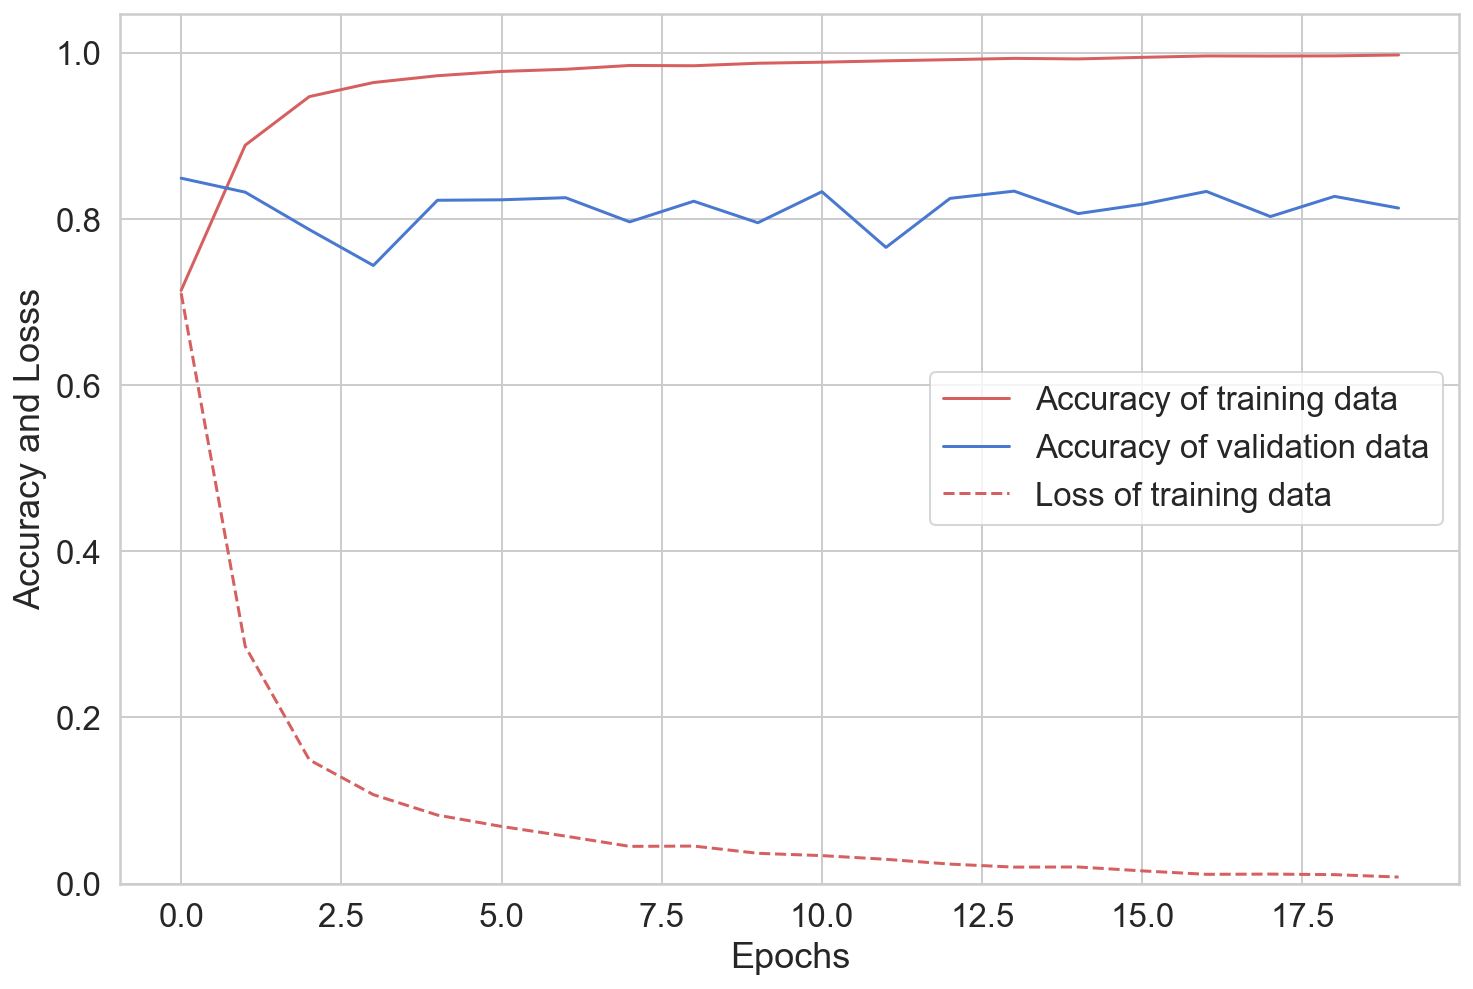

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.ylabel('Accuracy and Losss')
plt.xlabel('Epochs')
plt.ylim(0)
plt.legend()
plt.show()

In [7]:
score = test_model(test_df)
print('\nAccuracy on test data: %0.4f' % score[1])
print('\nLoss on test data: %0.4f' % score[0])

11249/11249 [==============================] - 3s 236us/step

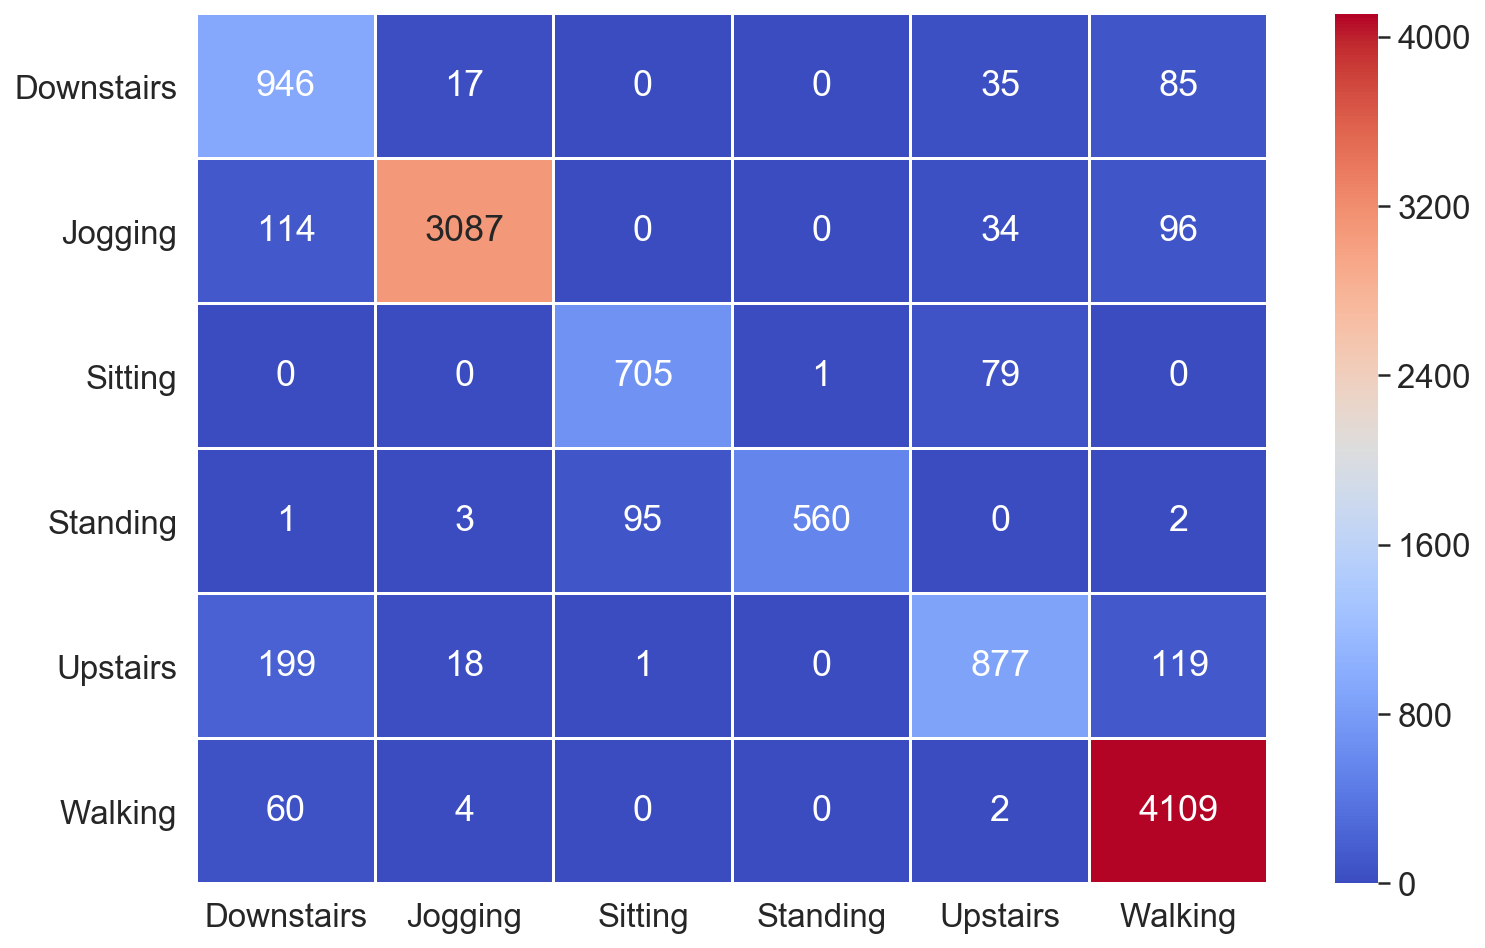

In [18]:
segments, labels = create_data_segmentation_and_activity_labels(test_df, window_size, step_size)
labels = apply_one_hot_encoding(labels)
predictions = model.predict(segments)

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=LABELS,
                yticklabels=LABELS, annot=True, fmt='d')
    plt.rcParams.update({'font.size': 20})
    plt.autoscale()
    plt.show()

max_predictions = np.argmax(predictions, axis=1)
max_labels = np.argmax(labels, axis=1)
show_confusion_matrix(max_labels, max_predictions)

In [ ]:
# Save model as JSON
model_json = model.to_json()
with open("../models/modelv2.json", "w") as json_file:
    json_file.write(model_json)
# Save model weights as HDF5
model.save_weights("../models/modelv2.h5")
print("Saved model to disk")